# Wstępna obróbka danych, definiowanie funkcji

In [ ]:
!pip install hurst

In [ ]:
# Importowanie bibliotek
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from hurst import compute_Hc  # Biblioteka do analizy Hurst


# Wczytanie danych
file_path = 'pkn2.xlsx'  # Upewnij się, że plik Excel jest załadowany do katalogu w Colab
data = pd.read_excel(file_path)

# Formatowanie daty i czasu
data['<DATETIME>'] = pd.to_datetime(data['<DATE>'].astype(str) + data['<TIME>'].astype(str), format='%Y%m%d%H%M%S')

# Sortowanie danych
data = data.sort_values(by='<DATETIME>').reset_index(drop=True)

# Wybór tylko istotnych kolumn
data = data[['<DATETIME>', '<OPEN>','<CLOSE>']]
data.rename(columns={'<CLOSE>': 'close'}, inplace=True)
data.rename(columns={'<DATETIME>': 'date'}, inplace=True)
data.rename(columns={'<OPEN>': 'open'}, inplace=True)

# Wyświetlenie pierwszych wierszy danych
data.head()



,date,open,close
0,2024-11-15 09:00:00,53.00,52.82
1,2024-11-15 09:05:00,52.77,52.69
2,2024-11-15 09:10:00,52.69,52.75
3,2024-11-15 09:15:00,52.77,52.65
4,2024-11-15 09:20:00,52.65,52.61


In [ ]:
# Funkcja do obliczenia logarytmicznych stóp zwrotu
def calculate_log_returns(data, price_col='close'):
    data['log_return'] = np.log(data[price_col] / data[price_col].shift(1))
    return data.dropna()

# Funkcja do resamplingu danych na różne interwały czasowe
def resample_data(data, interval):
    resampled = data.set_index('date').resample(interval).agg({
        'open': 'first',  # Pierwsza wartość w interwale
        'close': 'last',  # Ostatnia wartość w interwale
    }).dropna().reset_index()
    resampled = calculate_log_returns(resampled, price_col='close')  # Obliczanie stóp zwrotu
    return resampled

# Funkcja do obliczenia zmienności zrealizowanej
def realized_variance_version1(log_returns):
    return np.sum(log_returns**2)

def calculate_daily_realized_variance(data):
    data['date'] = pd.to_datetime(data['date'])
    # Grupowanie według daty (bez czasu) i obliczanie wariancji
    data['day'] = data['date'].dt.date  # Dodanie kolumny z samymi datami
    daily_variance = data.groupby('day')['log_return'].apply(realized_variance_version1)
    # Konwersja do DataFrame
    result = daily_variance.reset_index()
    result.rename(columns={'log_return': 'realized_variance'}, inplace=True)
    return result

def remove_rows_with_time(data, target_time):
    """
    Usuwa wszystkie wiersze, w których czas w kolumnie 'date' jest równy podanemu czasowi.

    Parametry:
    - data (pd.DataFrame): DataFrame zawierający dane z kolumną 'date' typu datetime.
    - target_time (str): Czas w formacie 'HH:MM:SS', który ma zostać usunięty.

    Zwraca:
    - pd.DataFrame: DataFrame bez wierszy z podanym czasem.
    """
    # Przekształcenie target_time na typ datetime.time
    target_time = pd.to_datetime(target_time).time()

    # Filtrowanie danych
    filtered_data = data[data['date'].dt.time != target_time]

    return filtered_data

# Funkcje do analizy rozkładu
# 1. Funkcja do analizy rozkładu (histogram i gęstość KDE)
def analyze_distribution(data):
    """
    Analizuje rozkład zmienności zrealizowanej (histogram i KDE).

    Parameters:
        data (pd.DataFrame): DataFrame z kolumną `realized_variance`.
    """
    plt.figure(figsize=(12, 6))

    # Histogram
    sns.histplot(data["realized_variance"], kde=True, bins=30, color="skyblue", label="Histogram")

    # Gęstość KDE
    sns.kdeplot(data["realized_variance"], color="red", label="KDE")

    plt.title("Rozkład zmienności zrealizowanej")
    plt.xlabel("Wartość zmienności")
    plt.ylabel("Gęstość")
    plt.legend()
    plt.show()

# 2. Funkcja do analizy długiej pamięci (Hurst exponent)
def compute_hurst_exponent(ts):
    """
    Oblicza wykładnik Hursta szeregu czasowego.
    """
    N = len(ts)
    if N < 20:
        raise ValueError("Szereg czasowy powinien mieć co najmniej 20 punktów.")

    # Krok 1: Oblicz średnią kroczącą
    mean_ts = np.mean(ts)

    # Krok 2: Odjęcie średniej i skumulowana suma
    ts_centered = ts - mean_ts
    cumulative_sum = np.cumsum(ts_centered)

    # Krok 3: Zakres przeskalowany (R/S)
    R = np.max(cumulative_sum) - np.min(cumulative_sum)
    S = np.std(ts_centered)

    # Unikamy dzielenia przez zero
    if S == 0:
        raise ValueError("Odchylenie standardowe szeregu czasowego wynosi 0.")

    RS = R / S

    # Przybliżenie wykładnika Hursta na podstawie logarytmu R/S
    hurst_exponent = np.log(RS) / np.log(N)
    return hurst_exponent

def compute_long_memory_parameter(data):
    """
    Oblicza parametr długiej pamięci (d) na podstawie wykładnika Hursta (H).

    Parametry:
        data (pd.DataFrame): DataFrame z kolumną 'realized_variance'.

    Zwraca:
        float: Oszacowana wartość długiej pamięci (d).
    """
    if "realized_variance" not in data.columns:
        raise ValueError("DataFrame musi zawierać kolumnę 'realized_variance'.")

    ts = data["realized_variance"].values

    # Oblicz Hurst exponent
    H = compute_hurst_exponent(ts)

    # Parametr długiej pamięci
    d = H - 0.5
    return d

# 3. Funkcja do rysowania korelogramu (ACF)
def plot_correlogram(data, lags=30):
    """
    Rysuje korelogram (ACF) dla danych.

    Parameters:
        data (pd.DataFrame): DataFrame z kolumną `realized_variance`.
        lags (int): Liczba lagów do uwzględnienia w ACF.
    """
    series = data["realized_variance"]

    plt.figure(figsize=(10, 5))
    plot_acf(series, lags=lags, alpha=0.05, title="Korelogram (ACF)")
    plt.show()

# 4. Funkcja główna
def analyze_realized_variance(data):
    """
    Przeprowadza analizę zmienności zrealizowanej:
    - Rozkład (histogram, KDE),
    - Długa pamięć (Hurst exponent),
    - Korelogram (ACF).

    Parameters:
        data (pd.DataFrame): DataFrame z kolumną `realized_variance`.
    """
    print("Analiza rozkładu zmienności:")
    analyze_distribution(data)

    print("\nAnaliza długiej pamięci:")
    H = compute_long_memory_parameter(data)
    print(f"\nParametr długiej pamięci (Hurst exponent): {H}")

    print("\nRysowanie korelogramu:")
    plot_correlogram(data)
# funckja do obliczenia trzeciego wzoru na zmiennosc zrealizowana
def calculate_realized_variance_corrected(data):
    """
    Funkcja oblicza dzienną zmienność zrealizowaną według poprawionego wzoru:
    sigma^2_{3,t} = (1 + c) * suma(r^2_{t,i})

    Parametr c jest obliczany jako stosunek wariancji dwóch szeregów czasowych:
    c = var_co / var_oc

    Gdzie:
    - var_co: wariancja stopy zwrotu między kursem zamknięcia a kursem otwarcia następnego dnia,
    - var_oc: wariancja stopy zwrotu dziennego, liczonego od kursu otwarcia do kursu zamknięcia.

    Funkcja ignoruje pierwszy rekord dnia podczas obliczania sumy kwadratów stóp zwrotu.

    Parametry:
    - data (pd.DataFrame): Dane wejściowe zawierające kolumny 'date', 'open', 'close'.

    Zwraca:
    - pd.DataFrame: DataFrame z kolumnami:
        * 'day': Data dzienna,
        * 'realized_variance': Zmienność zrealizowana po korekcie.
    """
    # Obliczenie stóp zwrotu między zamknięciem a otwarciem następnego dnia (co)
    data['co_return'] = data['close'].shift(1) / data['open'] - 1

    # Obliczenie stóp zwrotu dziennych (oc)
    data['oc_return'] = data['close'] / data['open'] - 1

    # Grupowanie po datach i obliczanie wariancji dla co i oc
    data['day'] = data['date'].dt.date
    daily_variances = data.groupby('day').apply(
        lambda group: pd.Series({
            'var_co': np.var(group['co_return'].dropna()),
            'var_oc': np.var(group['oc_return'].dropna())
        })
    ).reset_index()

    # Obliczenie parametru c jako średni stosunek wariancji co do oc
    daily_variances['c'] = daily_variances['var_co'] / daily_variances['var_oc']

    # Połączenie współczynnika c z oryginalnymi danymi
    data = data.merge(daily_variances[['day', 'c']], on='day', how='left')

    # Obliczenie \( \sum r^2_{t,i} \) dla każdego dnia, ignorując pierwszą wartość dnia
    data['squared_return'] = data['oc_return']**2
    daily_sum_squared = data.groupby('day').apply(
        lambda group: np.sum(group['squared_return'].iloc[1:])  # Pomijanie pierwszego rekordu dnia
    ).reset_index(name='sum_squared_returns')

    # Połączenie sumy kwadratów z oryginalnymi danymi
    data = data.merge(daily_sum_squared, on='day', how='left')

    # Obliczenie zmienności zrealizowanej według wzoru
    daily_variances['realized_variance'] = (
        1 + daily_variances['c']
    ) * daily_sum_squared['sum_squared_returns']

    return daily_variances[['day', 'realized_variance']]

In [ ]:
calculate_log_returns(data, 'close').head()

,date,open,close,log_return
1,2024-11-15 09:05:00,52.77,52.69,-0.002464
2,2024-11-15 09:10:00,52.69,52.75,0.001138
3,2024-11-15 09:15:00,52.77,52.65,-0.001898
4,2024-11-15 09:20:00,52.65,52.61,-0.000760
5,2024-11-15 09:25:00,52.70,52.63,0.000380


In [ ]:
data1 = data.copy()

# 5 min

In [ ]:
daily_realized_variance_overnight = calculate_daily_realized_variance(data)

print(daily_realized_variance_overnight)

           day  realized_variance
0   2024-11-15           0.000228
1   2024-11-18           0.000322
2   2024-11-19           0.000516
3   2024-11-20           0.000343
4   2024-11-21           0.000225
5   2024-11-22           0.000206
6   2024-11-25           0.000294
7   2024-11-26           0.000154
8   2024-11-27           0.000222
9   2024-11-28           0.000114
10  2024-11-29           0.000185
11  2024-12-02           0.000266
12  2024-12-03           0.000147
13  2024-12-04           0.000168
14  2024-12-05           0.000172
15  2024-12-06           0.000203
16  2024-12-09           0.000250
17  2024-12-10           0.000175
18  2024-12-11           0.000596
19  2024-12-12           0.000962
20  2024-12-13           0.000221
21  2024-12-16           0.000256
22  2024-12-17           0.000315
23  2024-12-18           0.000287
24  2024-12-19           0.000455
25  2024-12-20           0.000180
26  2024-12-23           0.000770
27  2024-12-27           0.000203
28  2024-12-30

Funkcja do stworzenia danych do badania wpływu overnight

In [ ]:
data2 = remove_rows_with_time(data, '09:00:00')

# Wyświetlenie wyników
data2.head()

,date,open,close,log_return,day
1,2024-11-15 09:05:00,52.77,52.69,-0.002464,2024-11-15
2,2024-11-15 09:10:00,52.69,52.75,0.001138,2024-11-15
3,2024-11-15 09:15:00,52.77,52.65,-0.001898,2024-11-15
4,2024-11-15 09:20:00,52.65,52.61,-0.000760,2024-11-15
5,2024-11-15 09:25:00,52.70,52.63,0.000380,2024-11-15


In [ ]:
daily_realized_variance_no_overnight = calculate_daily_realized_variance(data2)

print(daily_realized_variance_no_overnight)

           day  realized_variance
0   2024-11-15           0.000228
1   2024-11-18           0.000285
2   2024-11-19           0.000491
3   2024-11-20           0.000297
4   2024-11-21           0.000221
5   2024-11-22           0.000201
6   2024-11-25           0.000212
7   2024-11-26           0.000131
8   2024-11-27           0.000220
9   2024-11-28           0.000083
10  2024-11-29           0.000181
11  2024-12-02           0.000251
12  2024-12-03           0.000147
13  2024-12-04           0.000122
14  2024-12-05           0.000171
15  2024-12-06           0.000203
16  2024-12-09           0.000186
17  2024-12-10           0.000173
18  2024-12-11           0.000536
19  2024-12-12           0.000795
20  2024-12-13           0.000144
21  2024-12-16           0.000249
22  2024-12-17           0.000292
23  2024-12-18           0.000220
24  2024-12-19           0.000367
25  2024-12-20           0.000179
26  2024-12-23           0.000130
27  2024-12-27           0.000137
28  2024-12-30

<ipython-input-134-cdbc242becb5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-134-cdbc242becb5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date'].dt.date  # Dodanie kolumny z samymi datami


In [ ]:
daily_realized_variance_corrected = calculate_realized_variance_corrected(data)
print(daily_realized_variance_corrected)

<ipython-input-134-cdbc242becb5>:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_variances = data.groupby('day').apply(


           day  realized_variance
0   2024-11-15           0.000213
1   2024-11-18           0.000290
2   2024-11-19           0.000506
3   2024-11-20           0.000318
4   2024-11-21           0.000245
5   2024-11-22           0.000255
6   2024-11-25           0.000293
7   2024-11-26           0.000159
8   2024-11-27           0.000225
9   2024-11-28           0.000101
10  2024-11-29           0.000210
11  2024-12-02           0.000247
12  2024-12-03           0.000144
13  2024-12-04           0.000155
14  2024-12-05           0.000200
15  2024-12-06           0.000219
16  2024-12-09           0.000215
17  2024-12-10           0.000174
18  2024-12-11           0.001041
19  2024-12-12           0.000913
20  2024-12-13           0.000183
21  2024-12-16           0.000243
22  2024-12-17           0.000291
23  2024-12-18           0.000222
24  2024-12-19           0.000384
25  2024-12-20           0.000181
26  2024-12-23           0.000132
27  2024-12-27           0.000247
28  2024-12-30

<ipython-input-134-cdbc242becb5>:204: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_sum_squared = data.groupby('day').apply(


Badanie wlasnosci rozkladu zrealizowanej zmiennosci

Analiza rozkładu zmienności:


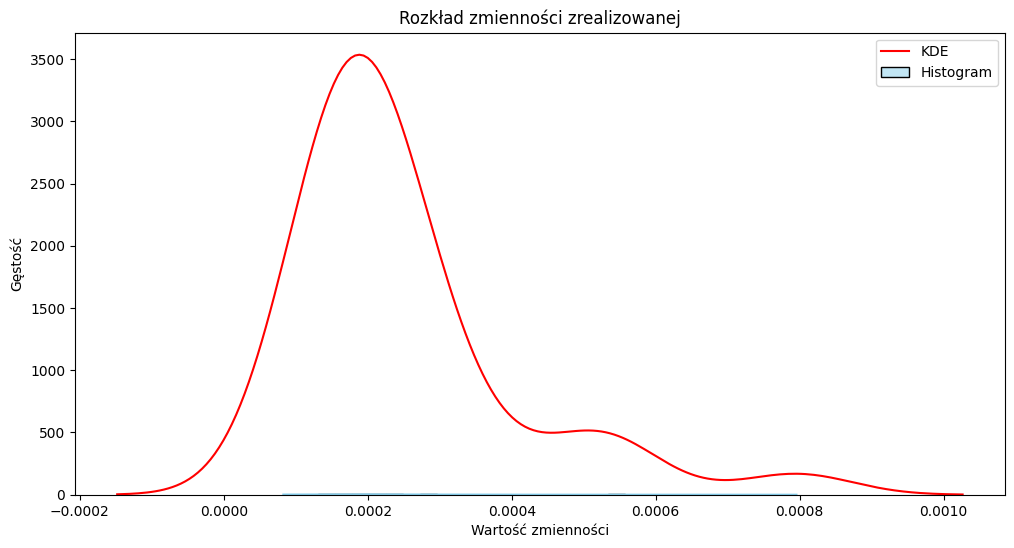


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.044027764810245285

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

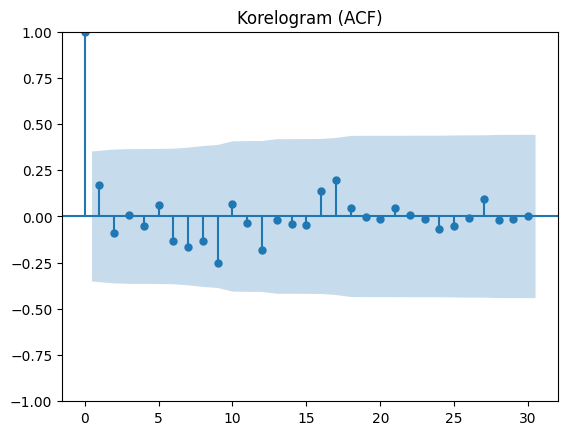

In [ ]:
analyze_realized_variance(daily_realized_variance_no_overnight)

Analiza rozkładu zmienności:


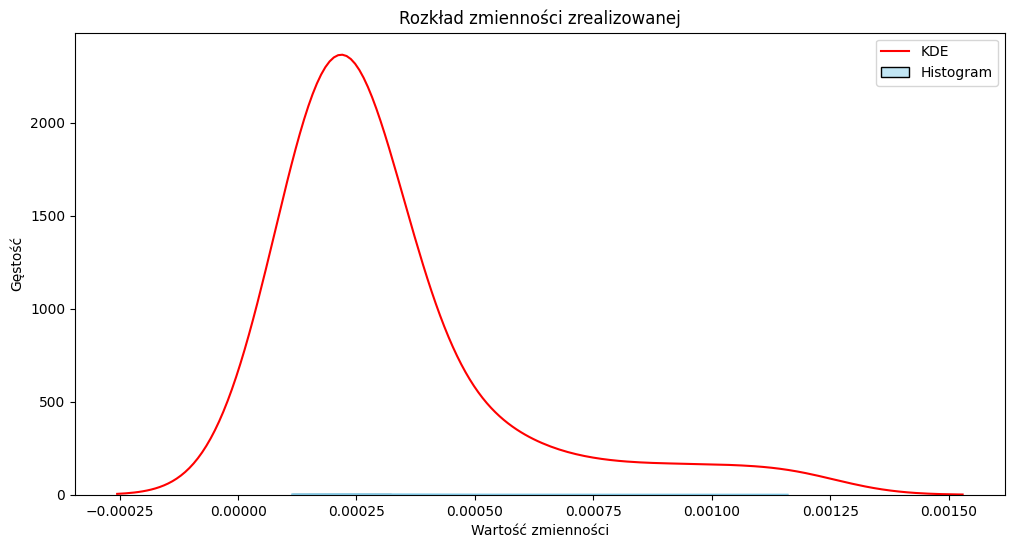


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.07484715084326088

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

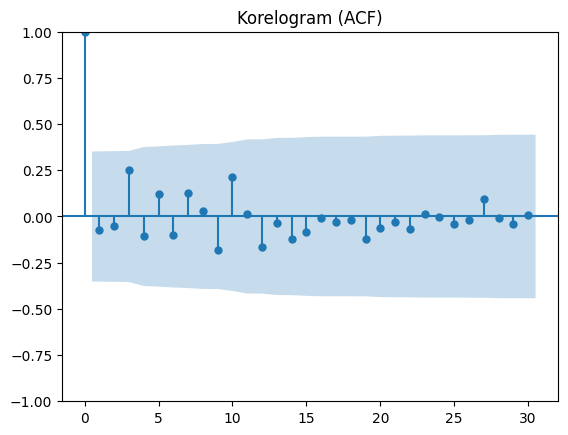

In [ ]:
analyze_realized_variance(daily_realized_variance_overnight)

Analiza rozkładu zmienności:


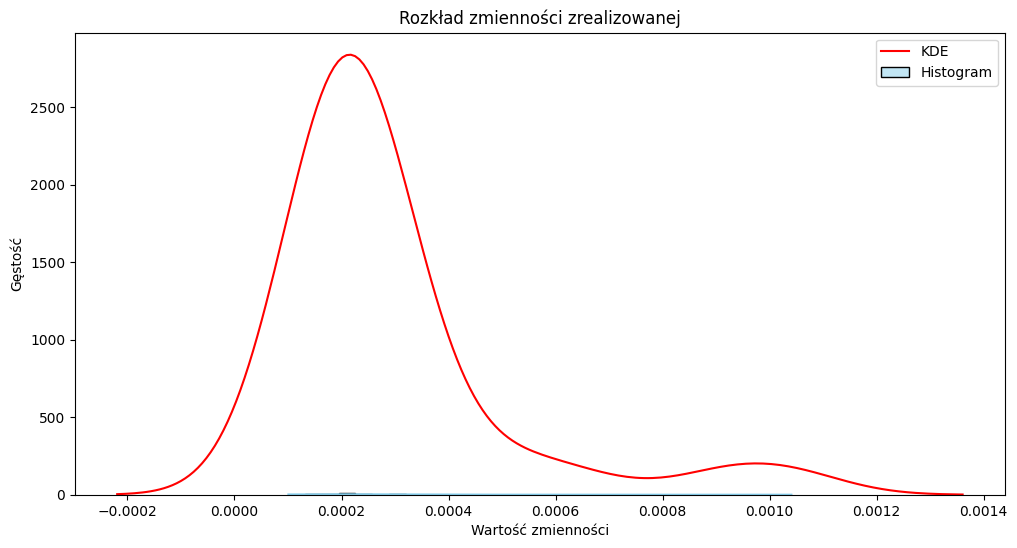


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.048974203505395386

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

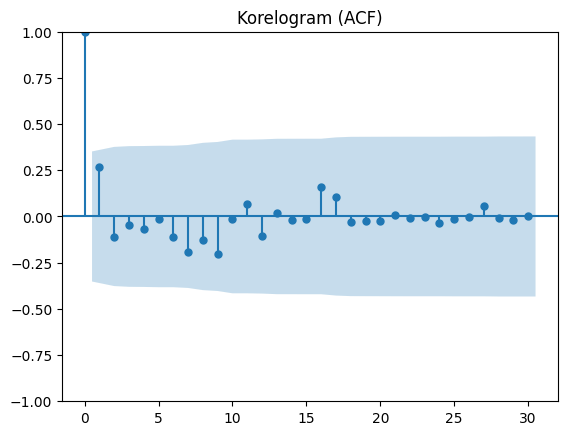

In [ ]:
analyze_realized_variance(daily_realized_variance_corrected)

# 10 min

In [ ]:
data = resample_data(data1, '10min')

In [ ]:
daily_realized_variance_overnight = calculate_daily_realized_variance(data)

print(daily_realized_variance_overnight)

           day  realized_variance
0   2024-11-15           0.000168
1   2024-11-18           0.000282
2   2024-11-19           0.000526
3   2024-11-20           0.000248
4   2024-11-21           0.000293
5   2024-11-22           0.000233
6   2024-11-25           0.000182
7   2024-11-26           0.000212
8   2024-11-27           0.000221
9   2024-11-28           0.000077
10  2024-11-29           0.000138
11  2024-12-02           0.000264
12  2024-12-03           0.000149
13  2024-12-04           0.000152
14  2024-12-05           0.000154
15  2024-12-06           0.000230
16  2024-12-09           0.000187
17  2024-12-10           0.000181
18  2024-12-11           0.000805
19  2024-12-12           0.000948
20  2024-12-13           0.000192
21  2024-12-16           0.000192
22  2024-12-17           0.000254
23  2024-12-18           0.000289
24  2024-12-19           0.000507
25  2024-12-20           0.000184
26  2024-12-23           0.000628
27  2024-12-27           0.000221
28  2024-12-30

Funkcja do stworzenia danych do badania wpływu overnight

In [ ]:
data2 = remove_rows_with_time(data, '09:00:00')

# Wyświetlenie wyników
data2.head()

,date,open,close,log_return,day
1,2024-11-15 09:10:00,52.69,52.65,-0.000759,2024-11-15
2,2024-11-15 09:20:00,52.65,52.63,-0.000380,2024-11-15
3,2024-11-15 09:30:00,52.63,52.66,0.000570,2024-11-15
4,2024-11-15 09:40:00,52.64,52.50,-0.003043,2024-11-15
5,2024-11-15 09:50:00,52.50,52.59,0.001713,2024-11-15


In [ ]:
daily_realized_variance_no_overnight = calculate_daily_realized_variance(data2)

print(daily_realized_variance_no_overnight)

           day  realized_variance
0   2024-11-15           0.000168
1   2024-11-18           0.000274
2   2024-11-19           0.000518
3   2024-11-20           0.000189
4   2024-11-21           0.000261
5   2024-11-22           0.000232
6   2024-11-25           0.000155
7   2024-11-26           0.000174
8   2024-11-27           0.000214
9   2024-11-28           0.000060
10  2024-11-29           0.000135
11  2024-12-02           0.000212
12  2024-12-03           0.000142
13  2024-12-04           0.000134
14  2024-12-05           0.000129
15  2024-12-06           0.000230
16  2024-12-09           0.000180
17  2024-12-10           0.000171
18  2024-12-11           0.000739
19  2024-12-12           0.000806
20  2024-12-13           0.000108
21  2024-12-16           0.000192
22  2024-12-17           0.000250
23  2024-12-18           0.000240
24  2024-12-19           0.000388
25  2024-12-20           0.000171
26  2024-12-23           0.000113
27  2024-12-27           0.000165
28  2024-12-30

<ipython-input-134-cdbc242becb5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-134-cdbc242becb5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date'].dt.date  # Dodanie kolumny z samymi datami


In [ ]:
daily_realized_variance_corrected = calculate_realized_variance_corrected(data)
print(daily_realized_variance_corrected)

           day  realized_variance
0   2024-11-15           0.000158
1   2024-11-18           0.000299
2   2024-11-19           0.000508
3   2024-11-20           0.000214
4   2024-11-21           0.000262
5   2024-11-22           0.000274
6   2024-11-25           0.000230
7   2024-11-26           0.000201
8   2024-11-27           0.000223
9   2024-11-28           0.000075
10  2024-11-29           0.000159
11  2024-12-02           0.000222
12  2024-12-03           0.000137
13  2024-12-04           0.000165
14  2024-12-05           0.000143
15  2024-12-06           0.000229
16  2024-12-09           0.000216
17  2024-12-10           0.000173
18  2024-12-11           0.001328
19  2024-12-12           0.000932
20  2024-12-13           0.000145
21  2024-12-16           0.000190
22  2024-12-17           0.000256
23  2024-12-18           0.000234
24  2024-12-19           0.000394
25  2024-12-20           0.000185
26  2024-12-23           0.000119
27  2024-12-27           0.000262
28  2024-12-30

<ipython-input-134-cdbc242becb5>:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_variances = data.groupby('day').apply(
<ipython-input-134-cdbc242becb5>:204: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_sum_squared = data.groupby('day').apply(


Badanie wlasnosci rozkladu zrealizowanej zmiennosci

Analiza rozkładu zmienności:


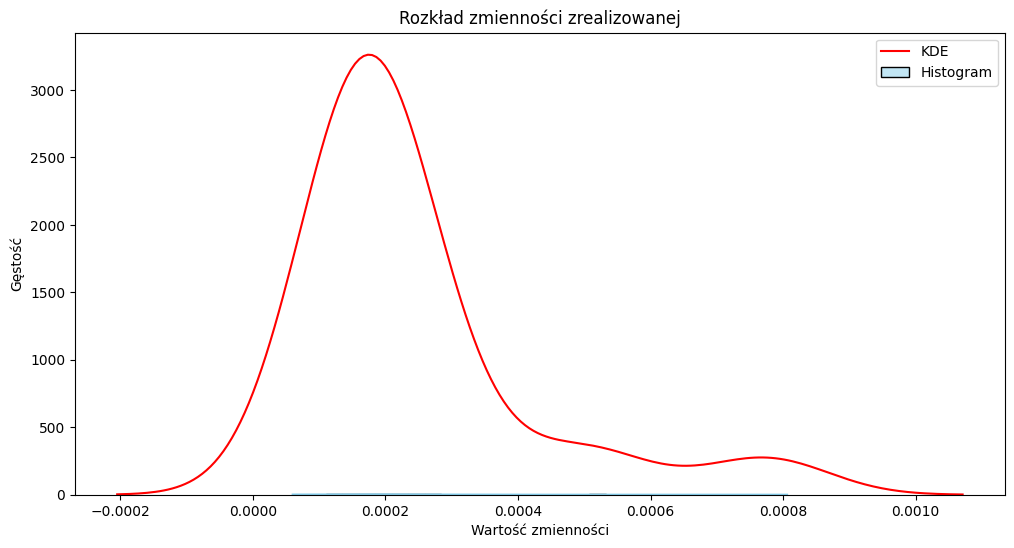


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.02841709853735186

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

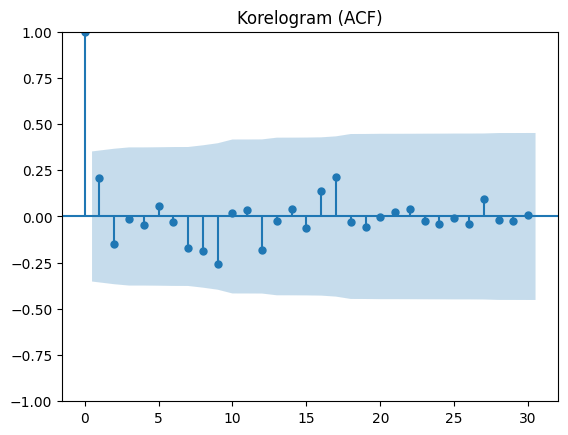

In [ ]:
analyze_realized_variance(daily_realized_variance_no_overnight)

Analiza rozkładu zmienności:


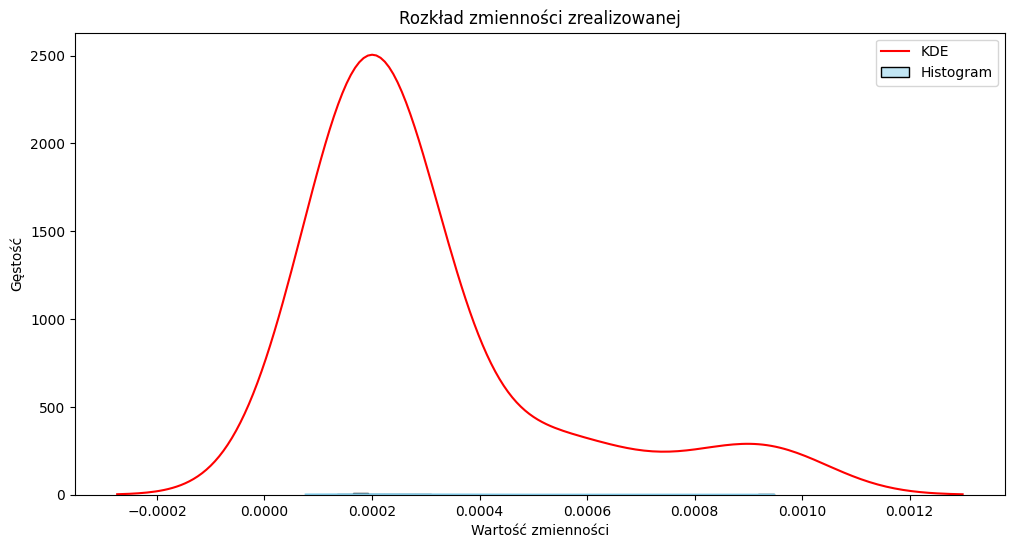


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.08523801094667605

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

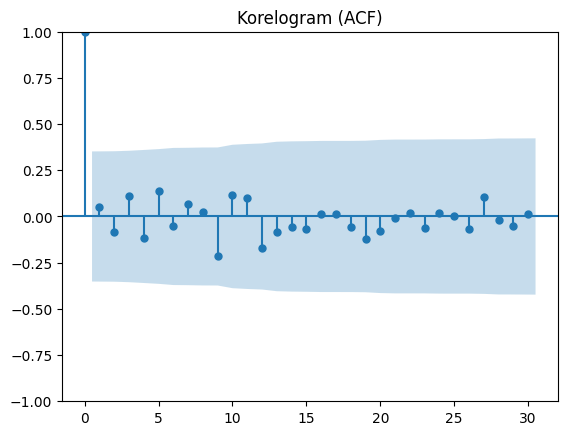

In [ ]:
analyze_realized_variance(daily_realized_variance_overnight)

Analiza rozkładu zmienności:


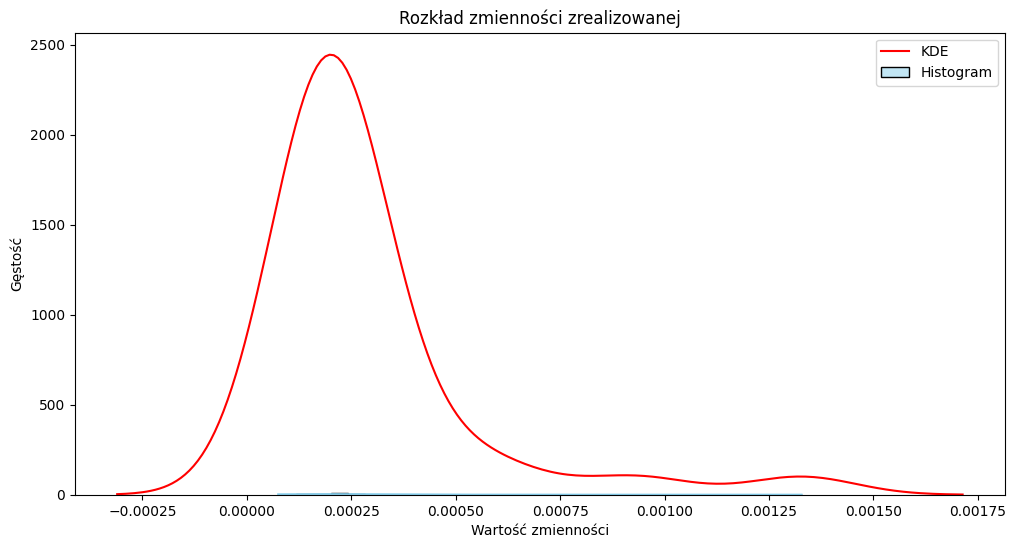


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.05443455334767322

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

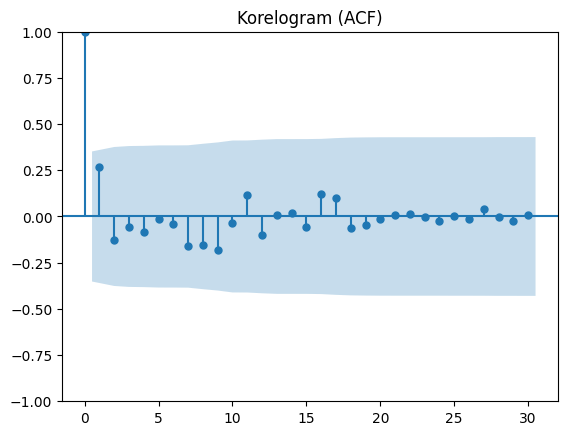

In [ ]:
analyze_realized_variance(daily_realized_variance_corrected)

# 15 min

In [ ]:
data = resample_data(data1, '15min')

In [ ]:
daily_realized_variance_overnight = calculate_daily_realized_variance(data)

print(daily_realized_variance_overnight)

           day  realized_variance
0   2024-11-15           0.000221
1   2024-11-18           0.000265
2   2024-11-19           0.000548
3   2024-11-20           0.000104
4   2024-11-21           0.000272
5   2024-11-22           0.000125
6   2024-11-25           0.000254
7   2024-11-26           0.000174
8   2024-11-27           0.000149
9   2024-11-28           0.000049
10  2024-11-29           0.000156
11  2024-12-02           0.000343
12  2024-12-03           0.000105
13  2024-12-04           0.000122
14  2024-12-05           0.000159
15  2024-12-06           0.000228
16  2024-12-09           0.000215
17  2024-12-10           0.000114
18  2024-12-11           0.000785
19  2024-12-12           0.001018
20  2024-12-13           0.000183
21  2024-12-16           0.000174
22  2024-12-17           0.000335
23  2024-12-18           0.000163
24  2024-12-19           0.000559
25  2024-12-20           0.000194
26  2024-12-23           0.000698
27  2024-12-27           0.000241
28  2024-12-30

Funkcja do stworzenia danych do badania wpływu overnight

In [ ]:
data2 = remove_rows_with_time(data, '09:00:00')

# Wyświetlenie wyników
data2.head()

,date,open,close,log_return,day
1,2024-11-15 09:15:00,52.77,52.63,-0.002277,2024-11-15
2,2024-11-15 09:30:00,52.63,52.55,-0.001521,2024-11-15
3,2024-11-15 09:45:00,52.54,52.59,0.000761,2024-11-15
4,2024-11-15 10:00:00,52.60,53.11,0.009839,2024-11-15
5,2024-11-15 10:15:00,53.09,52.95,-0.003017,2024-11-15


In [ ]:
daily_realized_variance_no_overnight = calculate_daily_realized_variance(data2)

print(daily_realized_variance_no_overnight)

           day  realized_variance
0   2024-11-15           0.000221
1   2024-11-18           0.000264
2   2024-11-19           0.000548
3   2024-11-20           0.000090
4   2024-11-21           0.000230
5   2024-11-22           0.000124
6   2024-11-25           0.000223
7   2024-11-26           0.000156
8   2024-11-27           0.000141
9   2024-11-28           0.000045
10  2024-11-29           0.000134
11  2024-12-02           0.000244
12  2024-12-03           0.000105
13  2024-12-04           0.000110
14  2024-12-05           0.000148
15  2024-12-06           0.000225
16  2024-12-09           0.000184
17  2024-12-10           0.000114
18  2024-12-11           0.000722
19  2024-12-12           0.000871
20  2024-12-13           0.000128
21  2024-12-16           0.000162
22  2024-12-17           0.000328
23  2024-12-18           0.000148
24  2024-12-19           0.000417
25  2024-12-20           0.000184
26  2024-12-23           0.000151
27  2024-12-27           0.000153
28  2024-12-30

<ipython-input-134-cdbc242becb5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-134-cdbc242becb5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date'].dt.date  # Dodanie kolumny z samymi datami


In [ ]:
daily_realized_variance_corrected = calculate_realized_variance_corrected(data)
print(daily_realized_variance_corrected)

           day  realized_variance
0   2024-11-15           0.000204
1   2024-11-18           0.000295
2   2024-11-19           0.000577
3   2024-11-20           0.000093
4   2024-11-21           0.000243
5   2024-11-22           0.000173
6   2024-11-25           0.000307
7   2024-11-26           0.000183
8   2024-11-27           0.000151
9   2024-11-28           0.000055
10  2024-11-29           0.000146
11  2024-12-02           0.000219
12  2024-12-03           0.000111
13  2024-12-04           0.000141
14  2024-12-05           0.000170
15  2024-12-06           0.000241
16  2024-12-09           0.000223
17  2024-12-10           0.000117
18  2024-12-11           0.001309
19  2024-12-12           0.000990
20  2024-12-13           0.000170
21  2024-12-16           0.000168
22  2024-12-17           0.000326
23  2024-12-18           0.000144
24  2024-12-19           0.000438
25  2024-12-20           0.000190
26  2024-12-23           0.000160
27  2024-12-27           0.000241
28  2024-12-30

<ipython-input-134-cdbc242becb5>:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_variances = data.groupby('day').apply(
<ipython-input-134-cdbc242becb5>:204: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_sum_squared = data.groupby('day').apply(


Badanie wlasnosci rozkladu zrealizowanej zmiennosci

Analiza rozkładu zmienności:


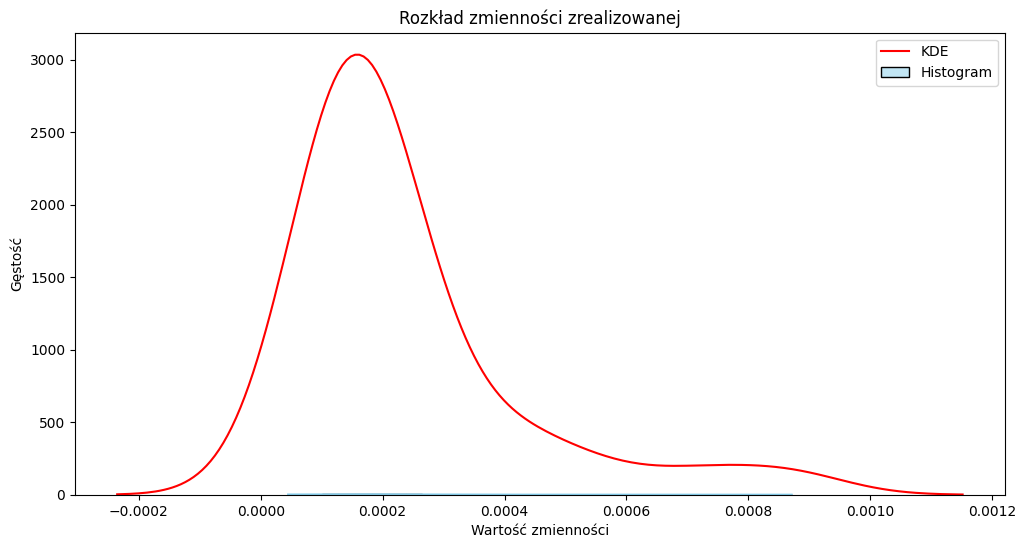


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.05939005660481245

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

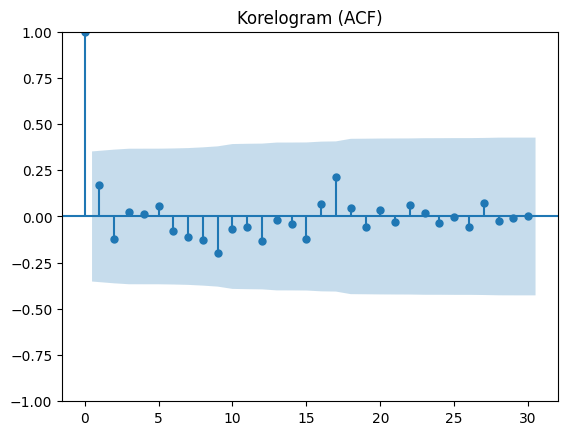

In [ ]:
analyze_realized_variance(daily_realized_variance_no_overnight)

Analiza rozkładu zmienności:


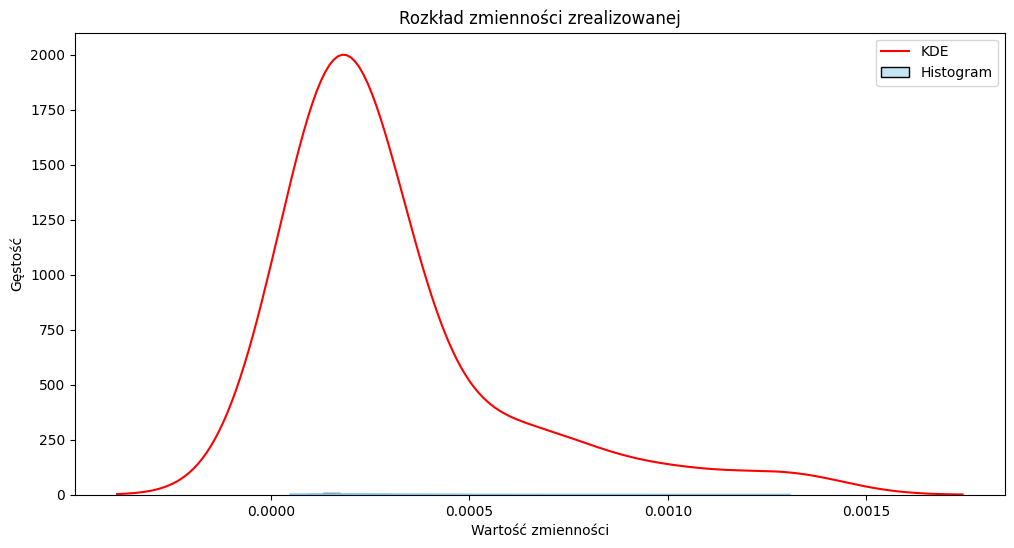


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.0837680308084181

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

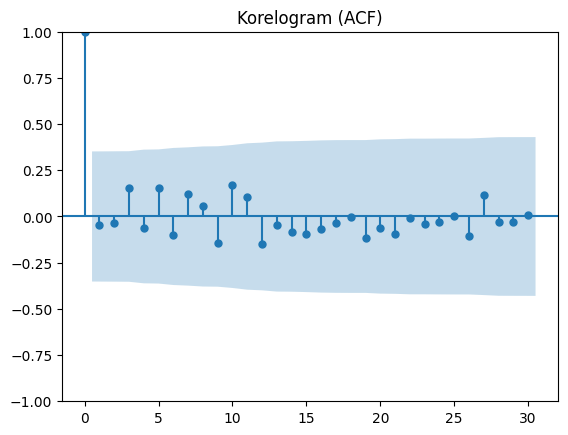

In [ ]:
analyze_realized_variance(daily_realized_variance_overnight)

Analiza rozkładu zmienności:


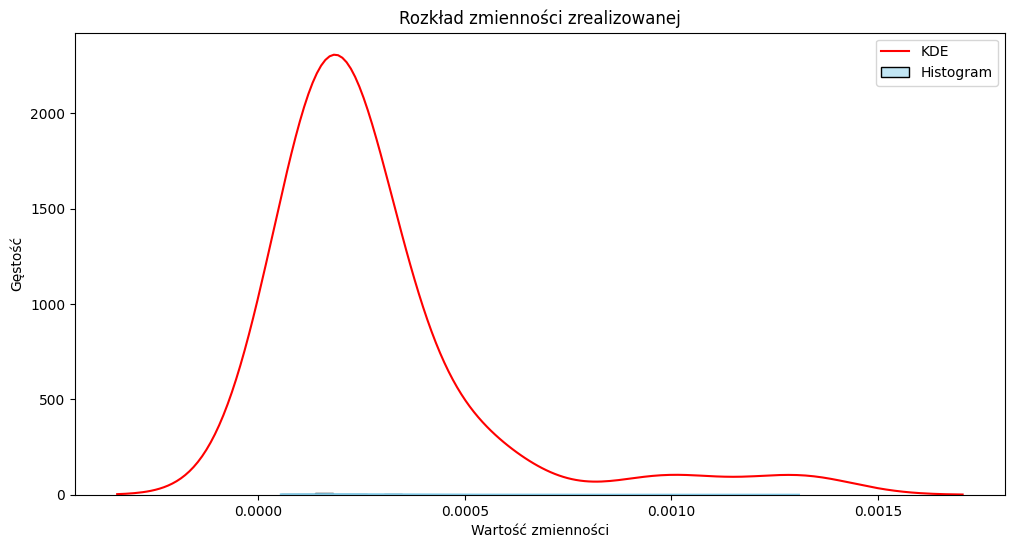


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.05582442988185177

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

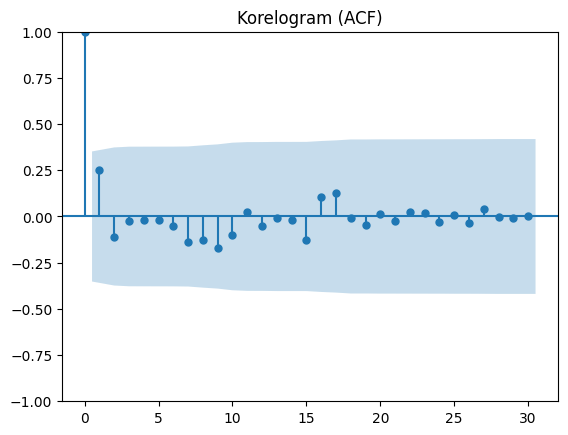

In [ ]:
analyze_realized_variance(daily_realized_variance_corrected)

# 30 min

In [ ]:
data = resample_data(data1, '30min')

In [ ]:
daily_realized_variance_overnight = calculate_daily_realized_variance(data)

print(daily_realized_variance_overnight)

           day  realized_variance
0   2024-11-15           0.000147
1   2024-11-18           0.000166
2   2024-11-19           0.000776
3   2024-11-20           0.000079
4   2024-11-21           0.000322
5   2024-11-22           0.000109
6   2024-11-25           0.000191
7   2024-11-26           0.000194
8   2024-11-27           0.000186
9   2024-11-28           0.000062
10  2024-11-29           0.000128
11  2024-12-02           0.000304
12  2024-12-03           0.000111
13  2024-12-04           0.000173
14  2024-12-05           0.000106
15  2024-12-06           0.000276
16  2024-12-09           0.000150
17  2024-12-10           0.000083
18  2024-12-11           0.001103
19  2024-12-12           0.000813
20  2024-12-13           0.000229
21  2024-12-16           0.000217
22  2024-12-17           0.000366
23  2024-12-18           0.000139
24  2024-12-19           0.000817
25  2024-12-20           0.000118
26  2024-12-23           0.000597
27  2024-12-27           0.000195
28  2024-12-30

Funkcja do stworzenia danych do badania wpływu overnight

In [ ]:
data2 = remove_rows_with_time(data, '09:00:00')

# Wyświetlenie wyników
data2.head()

,date,open,close,log_return,day
1,2024-11-15 09:30:00,52.63,52.59,-0.000760,2024-11-15
2,2024-11-15 10:00:00,52.60,52.95,0.006822,2024-11-15
3,2024-11-15 10:30:00,52.92,52.75,-0.003784,2024-11-15
4,2024-11-15 11:00:00,52.76,52.82,0.001326,2024-11-15
5,2024-11-15 11:30:00,52.87,53.04,0.004156,2024-11-15


In [ ]:
daily_realized_variance_no_overnight = calculate_daily_realized_variance(data2)

print(daily_realized_variance_no_overnight)

           day  realized_variance
0   2024-11-15           0.000147
1   2024-11-18           0.000158
2   2024-11-19           0.000776
3   2024-11-20           0.000077
4   2024-11-21           0.000275
5   2024-11-22           0.000108
6   2024-11-25           0.000141
7   2024-11-26           0.000188
8   2024-11-27           0.000179
9   2024-11-28           0.000051
10  2024-11-29           0.000127
11  2024-12-02           0.000260
12  2024-12-03           0.000111
13  2024-12-04           0.000151
14  2024-12-05           0.000088
15  2024-12-06           0.000196
16  2024-12-09           0.000150
17  2024-12-10           0.000082
18  2024-12-11           0.000565
19  2024-12-12           0.000762
20  2024-12-13           0.000083
21  2024-12-16           0.000190
22  2024-12-17           0.000366
23  2024-12-18           0.000126
24  2024-12-19           0.000422
25  2024-12-20           0.000109
26  2024-12-23           0.000146
27  2024-12-27           0.000105
28  2024-12-30

<ipython-input-134-cdbc242becb5>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['date'] = pd.to_datetime(data['date'])
<ipython-input-134-cdbc242becb5>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day'] = data['date'].dt.date  # Dodanie kolumny z samymi datami


In [ ]:
daily_realized_variance_corrected = calculate_realized_variance_corrected(data)
print(daily_realized_variance_corrected)

           day  realized_variance
0   2024-11-15           0.000135
1   2024-11-18           0.000192
2   2024-11-19           0.000783
3   2024-11-20           0.000083
4   2024-11-21           0.000284
5   2024-11-22           0.000159
6   2024-11-25           0.000216
7   2024-11-26           0.000212
8   2024-11-27           0.000184
9   2024-11-28           0.000065
10  2024-11-29           0.000143
11  2024-12-02           0.000248
12  2024-12-03           0.000116
13  2024-12-04           0.000172
14  2024-12-05           0.000097
15  2024-12-06           0.000192
16  2024-12-09           0.000193
17  2024-12-10           0.000085
18  2024-12-11           0.001514
19  2024-12-12           0.000879
20  2024-12-13           0.000113
21  2024-12-16           0.000189
22  2024-12-17           0.000364
23  2024-12-18           0.000121
24  2024-12-19           0.000426
25  2024-12-20           0.000112
26  2024-12-23           0.000166
27  2024-12-27           0.000189
28  2024-12-30

<ipython-input-134-cdbc242becb5>:189: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_variances = data.groupby('day').apply(
<ipython-input-134-cdbc242becb5>:204: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_sum_squared = data.groupby('day').apply(


Badanie wlasnosci rozkladu zrealizowanej zmiennosci

Analiza rozkładu zmienności:


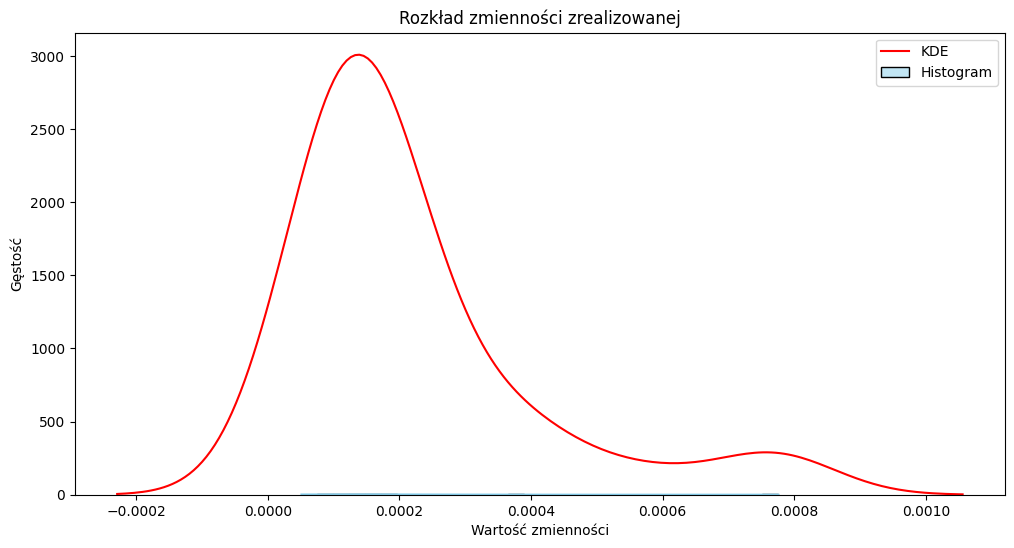


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.024967640480984543

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

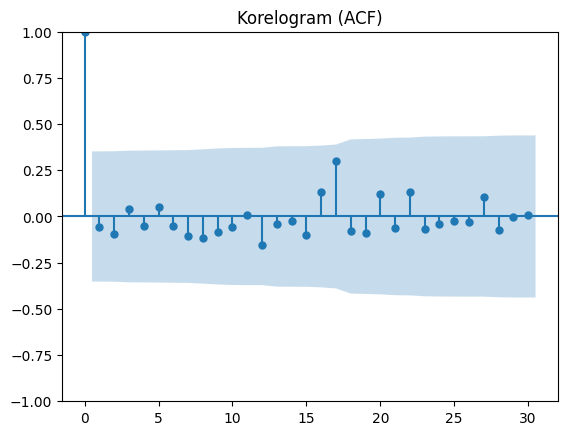

In [ ]:
analyze_realized_variance(daily_realized_variance_no_overnight)

Analiza rozkładu zmienności:


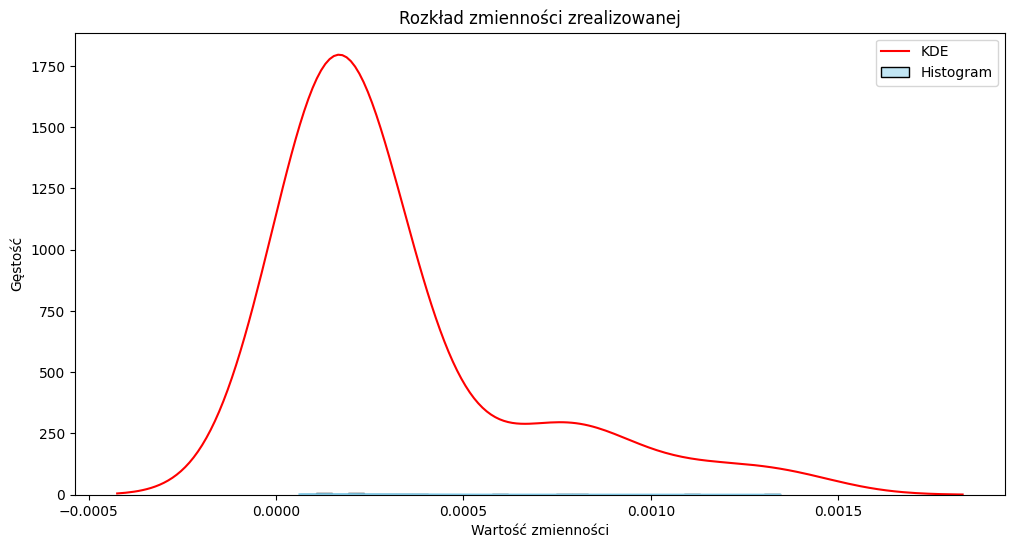


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.0822763766817457

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

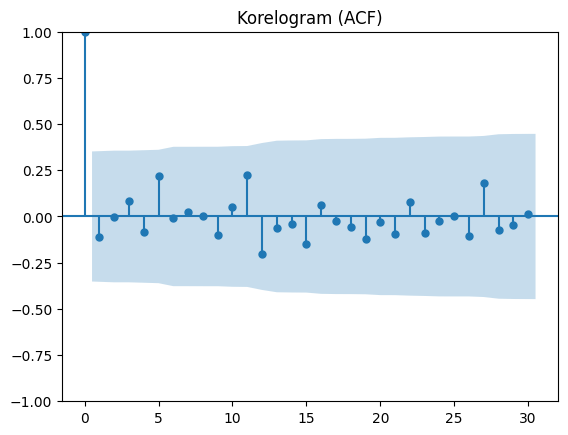

In [ ]:
analyze_realized_variance(daily_realized_variance_overnight)

Analiza rozkładu zmienności:


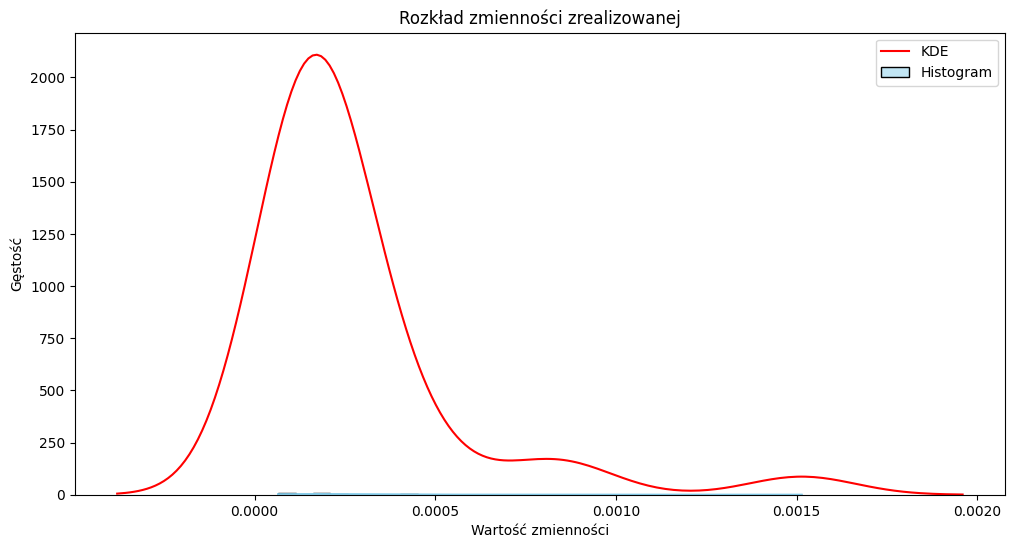


Analiza długiej pamięci:

Parametr długiej pamięci (Hurst exponent): 0.03915016793871684

Rysowanie korelogramu:


<Figure size 1000x500 with 0 Axes>

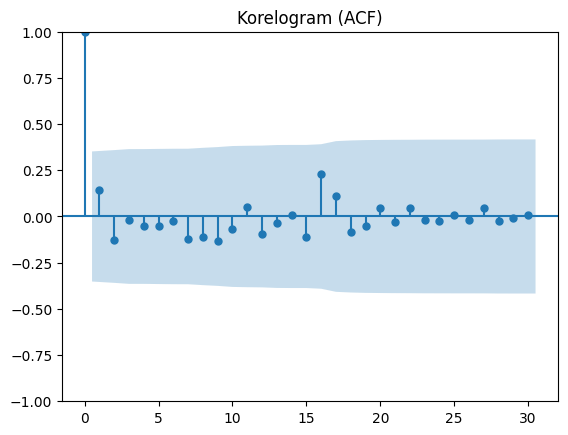

In [ ]:
analyze_realized_variance(daily_realized_variance_corrected)